In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'stixgeneral'
rcParams['mathtext.fontset'] = 'stix'

import pycbc
from pycbc import conversions, cosmology
from pycbc.distributions import Uniform, Gaussian
from pycbc.conversions import primary_mass, secondary_mass

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [43]:
def read_pycbc_data(cs5_file, uniform_file, dist):
    labels = ['lambda1', 'lambda2', 'lambda_tilde', 'mass1', 'mass2', 'radius', 'mchirp', 'eos', 'radius_1p4']
    samples_prior = {l: [] for l in labels}
    distance = 40.7

    dist_eos = Uniform(eos=(1, 2000.9))
    dist_m = Uniform(mass1=(1.0, 2.0), mass2=(1.0, 2.0))
    for (e,), (m1, m2) in zip(dist_eos.rvs(size=1000000), dist_m.rvs(size=1000000)):
        #if m1 < m2:
        #    continue
        m1p = primary_mass(m1, m2)
        m2s = secondary_mass(m1, m2)
        # apply mchirp
        mchirp = conversions.mchirp_from_mass1_mass2(m1p, m2s)
        if not 1.1876 < mchirp < 1.2076:
            continue

        e = int(e)

        MRLname = 'cs5MRL/'

        tov_file = '/Users/brendanking/Documents/LANL/LANL_Project_eos/' + MRLname + str(e) + '.dat'
        data = numpy.loadtxt(tov_file)
        radius_from_file = data[:, 0]
        mass_from_file = data[:, 1]
        lambda_from_file = data[:, 2]

        m1_src = m1p/(1.0 + pycbc.cosmology.redshift(distance))
        r1 = numpy.interp(m1_src, mass_from_file, radius_from_file)
        l1 = numpy.interp(m1_src, mass_from_file, lambda_from_file)

        m2_src = m2s/(1.0 + pycbc.cosmology.redshift(distance))
        l2 = numpy.interp(m2_src, mass_from_file, lambda_from_file)
        r2 = numpy.interp(m2_src, mass_from_file, radius_from_file)

        lt = conversions.lambda_tilde(m1_src, m2_src, l1, l2)

        r_1p4 = numpy.interp(1.4, mass_from_file, radius_from_file)

        samples_prior['mass1'].append(m1)
        samples_prior['mass2'].append(m2)
        samples_prior['lambda1'].append(l1)
        samples_prior['lambda2'].append(l2)
        samples_prior['lambda_tilde'].append(lt)
        samples_prior['radius_1p4'].append(r_1p4)


    samples_prior_uniform = {l: [] for l in labels}

    for (e,), (m1, m2) in zip(dist_eos.rvs(size=1000000), dist_m.rvs(size=1000000)):
        #if m1 < m2:
        #    continue
        m1p = primary_mass(m1, m2)
        m2s = secondary_mass(m1, m2)
        # apply mchirp
        mchirp = conversions.mchirp_from_mass1_mass2(m1p, m2s)
        if not 1.1876 < mchirp < 1.2076:
            continue

        e = int(e)

        MRLname = 'uniform/'

        tov_file = '/Users/brendanking/Documents/LANL/LANL_Project_eos/' + MRLname + str(e) + '.dat'
        data = numpy.loadtxt(tov_file)
        radius_from_file = data[:, 0]
        mass_from_file = data[:, 1]
        lambda_from_file = data[:, 2]

        m1_src = m1p/(1.0 + pycbc.cosmology.redshift(distance))
        r1 = numpy.interp(m1_src, mass_from_file, radius_from_file)
        l1 = numpy.interp(m1_src, mass_from_file, lambda_from_file)

        m2_src = m2s/(1.0 + pycbc.cosmology.redshift(distance))
        l2 = numpy.interp(m2_src, mass_from_file, lambda_from_file)
        r2 = numpy.interp(m2_src, mass_from_file, radius_from_file)

        lt = conversions.lambda_tilde(m1_src, m2_src, l1, l2)

        r_1p4 = numpy.interp(1.4, mass_from_file, radius_from_file)

        samples_prior_uniform['mass1'].append(m1)
        samples_prior_uniform['mass2'].append(m2)
        #samples4['mchirp'].append(mchirp)
        #samples4['radius'].append(r)
        #samples4['lambda_s'].append(l)
        samples_prior_uniform['lambda1'].append(l1)
        samples_prior_uniform['lambda2'].append(l2)
        samples_prior_uniform['lambda_tilde'].append(lt)
        samples_prior_uniform['radius_1p4'].append(r_1p4)

    from pycbc.inference.io import loadfile
    from pycbc.conversions import lambda_tilde

    samples_post = {l: [] for l in labels}

    fp=loadfile(cs5_file,'r+')

    m1=primary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
    m2=secondary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
    l1=fp['samples']['lambda1'][0:8000]
    l2=fp['samples']['lambda2'][0:8000]
    r1p4=fp['samples']['radius_1p4'][0:8000]

    samples_post['mass1'] = m1
    samples_post['mass2'] = m2
    samples_post['lambda1'] = l1
    samples_post['lambda2'] = l2
    samples_post['lambda_tilde'] = lambda_tilde(m1,m2,l1,l2)
    samples_post['radius_1p4'] = r1p4


    samples_post_uniform = {l: [] for l in labels}

    fp=loadfile(uniform_file,'r+')

    m1=primary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
    m2=secondary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
    l1=fp['samples']['lambda1'][0:8000]
    l2=fp['samples']['lambda2'][0:8000]
    r1p4=fp['samples']['radius_1p4'][0:8000]

    samples_post_uniform['mass1'] = m1
    samples_post_uniform['mass2'] = m2
    samples_post_uniform['lambda1'] = l1
    samples_post_uniform['lambda2'] = l2
    samples_post_uniform['lambda_tilde'] = lambda_tilde(m1,m2,l1,l2)
    samples_post_uniform['radius_1p4'] = r1p4
    
    return samples_prior, samples_prior_uniform, samples_post, samples_post_uniform

In [10]:
cs5_file = '../data/cs5_inj20_0130_ind.hdf'
uniform_file = '../data/uniform_inj20_0130_ind.hdf'
distance = 20.7

samples_prior_inj20, samples_prior_uniform_inj20, samples_post_inj20, samples_post_uniform_inj20 = read_pycbc_data(cs5_file,uniform_file, dist=distance)

In [28]:
cs5_file = '../data/cs5_inj30_0220_ind.hdf'
uniform_file = '../data/uniform_inj30_0313_ind.hdf'
distance = 30.7

samples_prior_inj30, samples_prior_uniform_inj30, samples_post_inj30, samples_post_uniform_inj30 = read_pycbc_data(cs5_file,uniform_file, dist=distance)

In [29]:
cs5_file = '../data/cs5_inj40_1128_ind.hdf'
uniform_file = '../data/uniform_inj40_ind.hdf'
distance = 40.7

samples_prior_inj40, samples_prior_uniform_inj40, samples_post_inj40, samples_post_uniform_inj40 = read_pycbc_data(cs5_file,uniform_file, dist=distance)

In [12]:
cs5_file = '../data/cs5_0829_ind.hdf'
uniform_file = '../data/uniform_1010_ind.hdf'
distance = 40.7

samples_prior, samples_prior_uniform, samples_post, samples_post_uniform = read_pycbc_data(cs5_file,uniform_file, dist=distance)

In [33]:
#get medians for plots
uniform_median = np.mean(samples_post_uniform['radius_1p4'])
cs5_median = np.mean(samples_post['radius_1p4'])
uniform_inj20_median = np.mean(samples_post_uniform_inj20['radius_1p4'])
cs5_inj20_median = np.mean(samples_post_inj20['radius_1p4'])
uniform_inj30_median = np.mean(samples_post_uniform_inj30['radius_1p4'])
cs5_inj30_median = np.mean(samples_post_inj30['radius_1p4'])
uniform_inj40_median = np.mean(samples_post_uniform_inj40['radius_1p4'])
cs5_inj40_median = np.mean(samples_post_inj40['radius_1p4'])

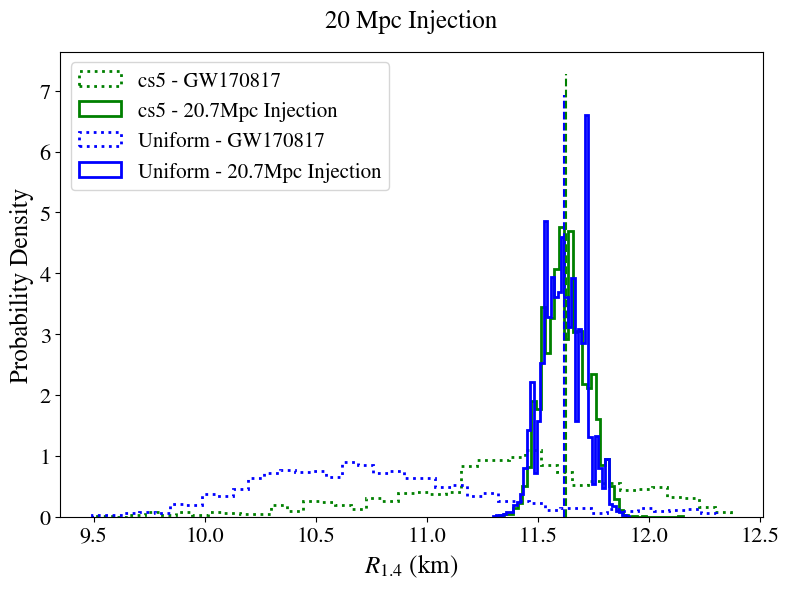

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
num_bins = 40

ax.hist(samples_post['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='green', 
        ls='dotted', lw=2, density=True, label=r"cs5 - GW170817")
ax.hist(samples_post_inj20['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='green', ls='solid', lw=2,
        density=True, label=r"cs5 - 20.7Mpc Injection")

ax.hist(samples_post_uniform['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='blue',
        ls='dotted', lw=2, density=True, label=r"Uniform - GW170817")
ax.hist(samples_post_uniform_inj20['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='blue', ls='solid', lw=2,
        density=True, label=r"Uniform - 20.7Mpc Injection")

ax.vlines(uniform_inj_median, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], ls='--', color='blue')
ax.vlines(cs5_inj_median, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], ls='--', color='green')

plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel(r"$R_{1.4}$ (km)", fontsize=18)
plt.ylabel(r"Probability Density", fontsize=18)
plt.legend(fontsize=15)
plt.title('20 Mpc Injection', fontsize=18, pad=18)
plt.tight_layout()
plt.savefig("../plots/r1p4_inj_comparison.png")

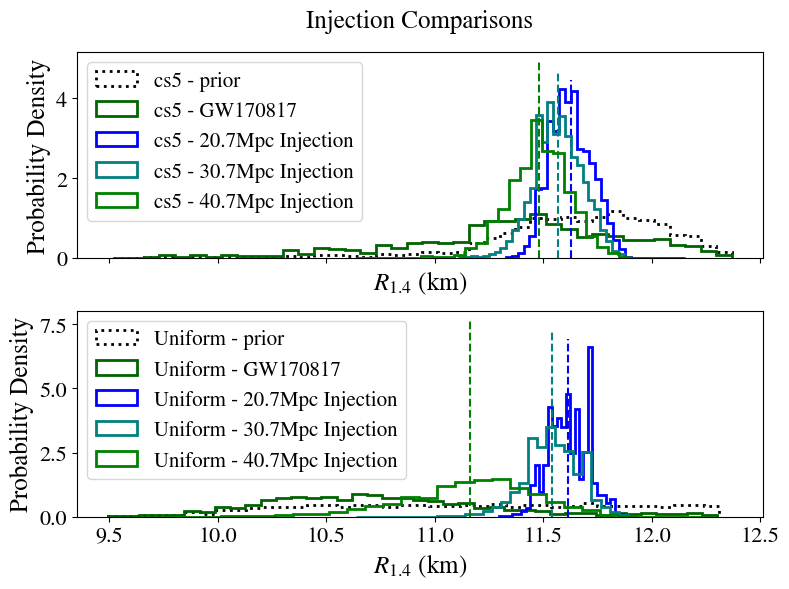

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(, 6), sharex=True)
num_bins = 30

ax[0].hist(samples_prior['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='black', 
        ls='dotted', lw=2, density=True, label=r"cs5 - prior")
ax[0].hist(samples_post['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='darkgreen', 
        ls='solid', lw=2, density=True, label=r"cs5 - GW170817")
ax[0].hist(samples_post_inj20['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='blue', ls='solid', lw=2,
        density=True, label=r"cs5 - 20.7Mpc Injection")
ax[0].vlines(cs5_inj20_median, ymin=ax[0].get_ylim()[0], ymax=ax[0].get_ylim()[1], ls='--', color='blue')
ax[0].hist(samples_post_inj30['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='teal', ls='solid', lw=2,
        density=True, label=r"cs5 - 30.7Mpc Injection")
ax[0].vlines(cs5_inj30_median, ymin=ax[0].get_ylim()[0], ymax=ax[0].get_ylim()[1], ls='--', color='teal')
ax[0].hist(samples_post_inj40['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='green', ls='solid', lw=2,
        density=True, label=r"cs5 - 40.7Mpc Injection")
ax[0].vlines(cs5_inj40_median, ymin=ax[0].get_ylim()[0], ymax=ax[0].get_ylim()[1], ls='--', color='green')

ax[1].hist(samples_prior_uniform['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='black',
        ls='dotted', lw=2, density=True, label=r"Uniform - prior")
ax[1].hist(samples_post_uniform['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='darkgreen',
        ls='solid', lw=2, density=True, label=r"Uniform - GW170817")
ax[1].hist(samples_post_uniform_inj20['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='blue', ls='solid', lw=2,
        density=True, label=r"Uniform - 20.7Mpc Injection")
ax[1].vlines(uniform_inj20_median, ymin=ax[1].get_ylim()[0], ymax=ax[1].get_ylim()[1], ls='--', color='blue')
ax[1].hist(samples_post_uniform_inj30['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='teal', ls='solid', lw=2,
        density=True, label=r"Uniform - 30.7Mpc Injection")
ax[1].vlines(uniform_inj30_median, ymin=ax[1].get_ylim()[0], ymax=ax[1].get_ylim()[1], ls='--', color='teal')
ax[1].hist(samples_post_uniform_inj40['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='green', ls='solid', lw=2,
        density=True, label=r"Uniform - 40.7Mpc Injection")
ax[1].vlines(uniform_inj40_median, ymin=ax[1].get_ylim()[0], ymax=ax[1].get_ylim()[1], ls='--', color='green')


ax[0].set_title('Injection Comparisons', fontsize=18, pad=18)
   
for j in range(len(ax)):
    ax[j].tick_params(axis='both', which='major', labelsize=16)
    ax[j].set_xlabel(r"$R_{1.4}$ (km)", fontsize=18)
    ax[j].set_ylabel(r"Probability Density", fontsize=18)
    ax[j].legend(fontsize=15)
    
plt.tight_layout()    
plt.savefig("../plots/compare_injs2gw170817.png")

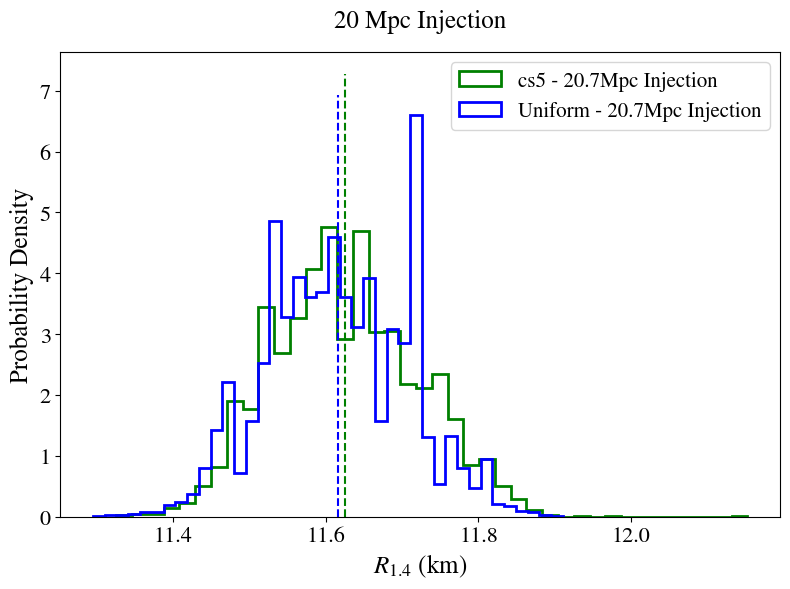

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
num_bins = 40

ax.hist(samples_post_inj20['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='green', ls='solid', lw=2,
        density=True, label=r"cs5 - 20.7Mpc Injection")

ax.hist(samples_post_uniform_inj20['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='blue', ls='solid', lw=2,
        density=True, label=r"Uniform - 20.7Mpc Injection")

ax.vlines(uniform_inj20_median, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], ls='--', color='blue')
ax.vlines(cs5_inj20_median, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], ls='--', color='green')

plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel(r"$R_{1.4}$ (km)", fontsize=18)
plt.ylabel(r"Probability Density", fontsize=18)
plt.legend(fontsize=15)
plt.title('20 Mpc Injection', fontsize=18, pad=18)
plt.tight_layout()
plt.savefig("../plots/r1p4_inj20_comparison.png")

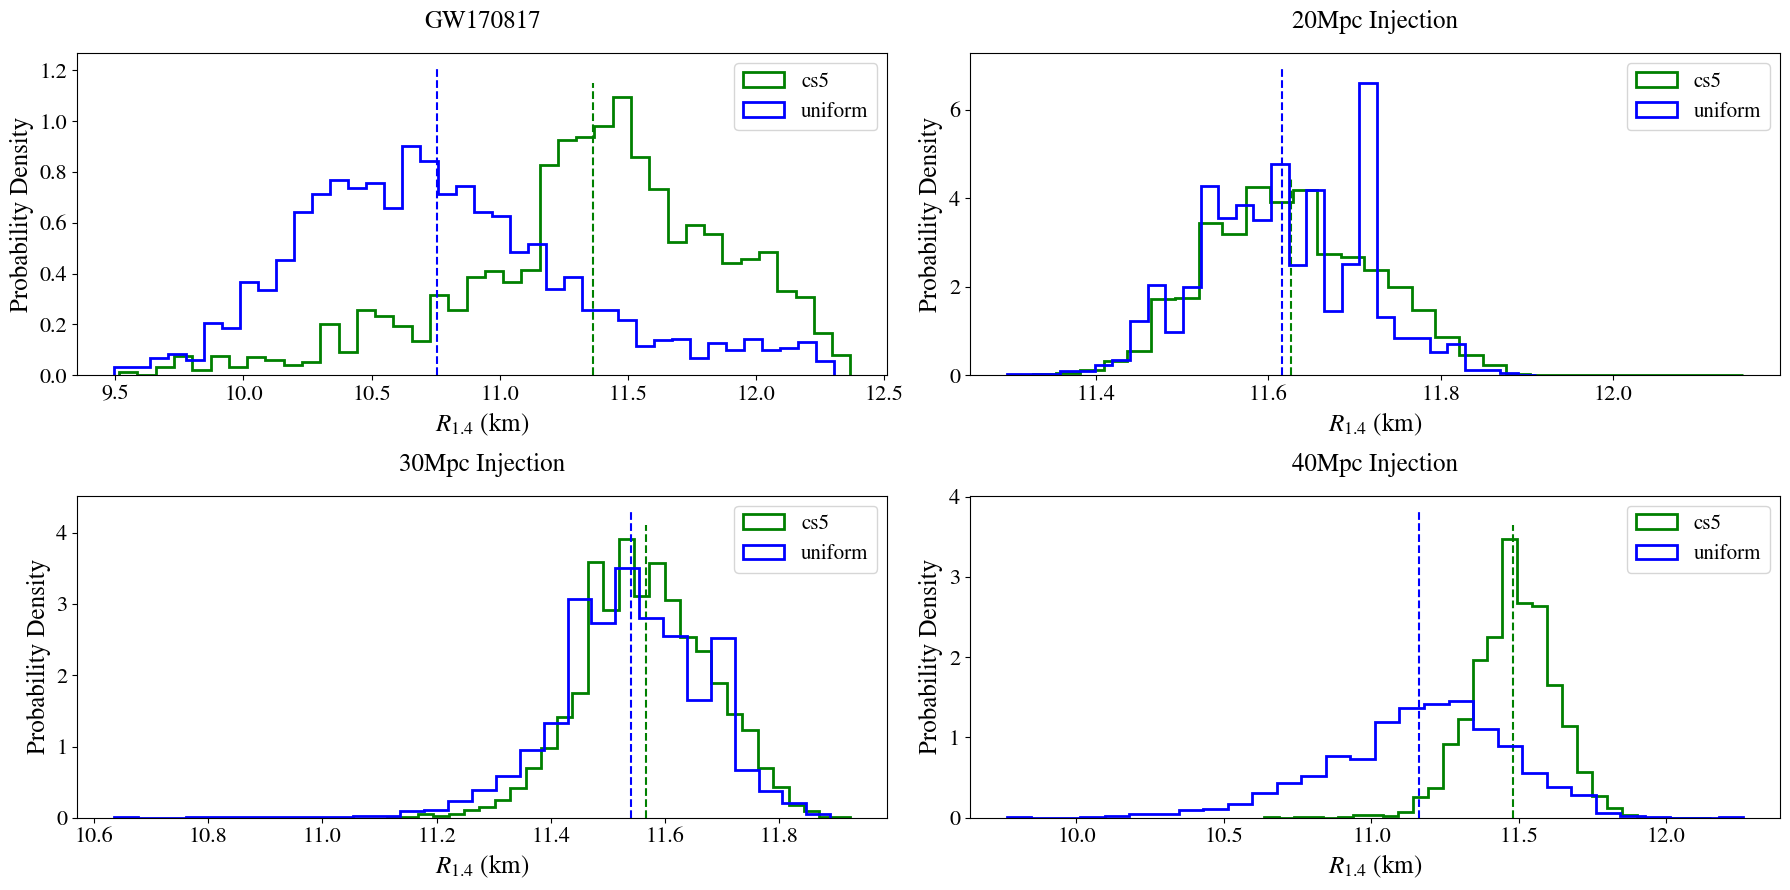

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(18, 9))
num_bins = 30

ax[0,0].hist(samples_post['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='green', 
        ls='solid', lw=2, density=True, label=r"cs5")
ax[0,0].vlines(cs5_median, ymin=ax[0,0].get_ylim()[0], ymax=ax[0,0].get_ylim()[1], ls='--', color='green')
ax[0,1].hist(samples_post_inj20['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='green', ls='solid', lw=2,
        density=True, label=r"cs5")
ax[0,1].vlines(cs5_inj20_median, ymin=ax[0,1].get_ylim()[0], ymax=ax[0,1].get_ylim()[1], ls='--', color='green')
ax[1,0].hist(samples_post_inj30['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='green', ls='solid', lw=2,
        density=True, label=r"cs5")
ax[1,0].vlines(cs5_inj30_median, ymin=ax[1,0].get_ylim()[0], ymax=ax[1,0].get_ylim()[1], ls='--', color='green')
ax[1,1].hist(samples_post_inj40['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='green', ls='solid', lw=2,
        density=True, label=r"cs5")
ax[1,1].vlines(cs5_inj40_median, ymin=ax[1,1].get_ylim()[0], ymax=ax[1,1].get_ylim()[1], ls='--', color='green')

ax[0,0].hist(samples_post_uniform['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='blue', 
        ls='solid', lw=2, density=True, label=r"uniform")
ax[0,0].vlines(uniform_median, ymin=ax[0,0].get_ylim()[0], ymax=ax[0,0].get_ylim()[1], ls='--', color='blue')
ax[0,1].hist(samples_post_uniform_inj20['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='blue', ls='solid', lw=2,
        density=True, label=r"uniform")
ax[0,1].vlines(uniform_inj20_median, ymin=ax[0,1].get_ylim()[0], ymax=ax[0,1].get_ylim()[1], ls='--', color='blue')
ax[1,0].hist(samples_post_uniform_inj30['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='blue', ls='solid', lw=2,
        density=True, label=r"uniform")
ax[1,0].vlines(uniform_inj30_median, ymin=ax[1,0].get_ylim()[0], ymax=ax[1,0].get_ylim()[1], ls='--', color='blue')
ax[1,1].hist(samples_post_uniform_inj40['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='blue', ls='solid', lw=2,
        density=True, label=r"uniform")
ax[1,1].vlines(uniform_inj40_median, ymin=ax[1,1].get_ylim()[0], ymax=ax[1,1].get_ylim()[1], ls='--', color='blue')


ax[0,0].legend(fontsize=15)
ax[0,0].set_title('GW170817', fontsize=18, pad=18)
ax[0,0].tick_params(axis='both', which='major', labelsize=16)
ax[0,0].set_xlabel(r"$R_{1.4}$ (km)", fontsize=18)
ax[0,0].set_ylabel(r"Probability Density", fontsize=18)

ax[0,1].legend(fontsize=15)
ax[0,1].set_title('20Mpc Injection', fontsize=18, pad=18)
ax[0,1].tick_params(axis='both', which='major', labelsize=16)
ax[0,1].set_xlabel(r"$R_{1.4}$ (km)", fontsize=18)
ax[0,1].set_ylabel(r"Probability Density", fontsize=18)

ax[1,0].legend(fontsize=15)
ax[1,0].set_title('30Mpc Injection', fontsize=18, pad=18)
ax[1,0].tick_params(axis='both', which='major', labelsize=16)
ax[1,0].set_xlabel(r"$R_{1.4}$ (km)", fontsize=18)
ax[1,0].set_ylabel(r"Probability Density", fontsize=18)

ax[1,1].legend(fontsize=15)
ax[1,1].set_title('40Mpc Injection', fontsize=18, pad=18)
ax[1,1].tick_params(axis='both', which='major', labelsize=16)
ax[1,1].set_xlabel(r"$R_{1.4}$ (km)", fontsize=18)
ax[1,1].set_ylabel(r"Probability Density", fontsize=18)


plt.tight_layout()
plt.savefig("../plots/uniform2cs5_comparison.png")